In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [14]:
df=pd.read_csv(r'/gdrive/MyDrive/Colab Notebooks/Datasets/Quora_train.csv',encoding='latin-1')

In [16]:
df=df.iloc[:5000]

In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [18]:
df.question1[0]

'What is the step by step guide to invest in share market in india?'

In [19]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

### TF-IDF Vectorization

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
#here applying making question bank of all q1 and q2 for calculating tfidf

questions = df['question1'].to_list() + df['question2'].to_list()
questions[:5]

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?']

In [54]:
questions_splitted=[]

for sent in questions:
  questions_splitted.append(sent.split())

In [75]:
#training tfidf
tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit(questions)

#creating dictionary of tfidf_features and their idf values
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [76]:
len(word2tfidf)

11794

In [60]:
nlp=spacy.load('en_core_web_sm')

In [62]:
doc1=nlp(df['question1'][0])

In [74]:
mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
mean_vec1.shape

(15, 96)

In [82]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 5000/5000 [00:48<00:00, 102.25it/s]


In [86]:
len(vecs1)

5000

In [92]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
df=pd.read_csv(r'/gdrive/MyDrive/Colab Notebooks/Datasets/nlp_features_train.csv',encoding='latin-1')

In [88]:
dfp_subsampled = df[0:5000]

In [90]:
dfp_subsampled.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [93]:
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [100]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5,perplexity=40
).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.128135
[t-SNE] Computed conditional probabilities in 0.344s
[t-SNE] Iteration 50: error = 77.5577240, gradient norm = 0.0369418 (50 iterations in 2.651s)
[t-SNE] Iteration 100: error = 67.6363449, gradient norm = 0.0082202 (50 iterations in 1.954s)
[t-SNE] Iteration 150: error = 66.0817184, gradient norm = 0.0061441 (50 iterations in 1.896s)
[t-SNE] Iteration 200: error = 65.3914795, gradient norm = 0.0043795 (50 iterations in 1.843s)
[t-SNE] Iteration 250: error = 64.9695129, gradient norm = 0.003799

In [101]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
df.head(5)

,x,y,label
0,-23.260717,-53.567318,0
1,-18.847498,-20.927601,0
2,-5.786746,2.816498,0
3,90.341034,1.054024,0
4,-21.901217,3.008955,0


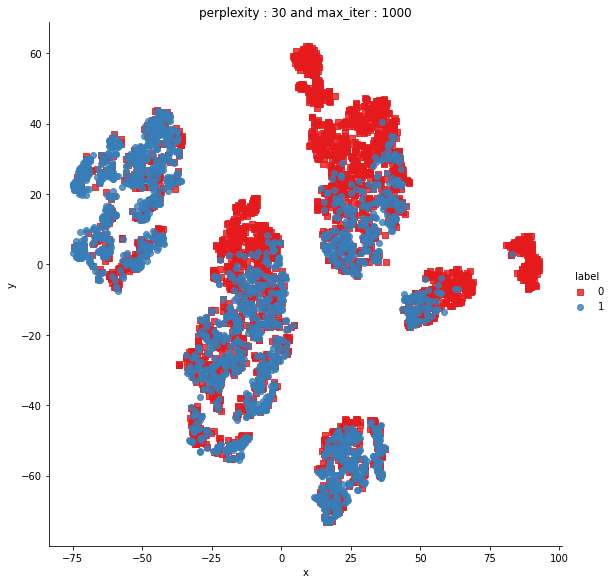

In [102]:
import seaborn as sns

sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()